# Data Immersion. Task 6.6 Sourcing & Analyzing Time-Series Data

### Table of Content:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity. Dickey-Fuller Test and Autocorrelation.
#### 5. Stationarizing the Crude Oil Prices: Brent - Europe [DCOILBRENTEU] Data

### 1. Importing libraries and data

In [11]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how plots will appear

In [13]:
# Configure API key 

quandl.ApiConfig.api_key = '8_z3osdEtz5LPsisbUhJ'

In [30]:
# Importing the Federal Reserve Economic Data "U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU]" variable.

data = quandl.get('FRED/DCOILBRENTEU')

#### Crude Oil Price: Brent-Europe. 
#####  This data set in NOT SEASONALLY adjusted. 
##### The Frequency is DAILY. 
##### Time span is 1987-2024.

In [23]:
data.head(5)

,Value
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [34]:
data.shape

(8887, 1)

In [36]:
data.columns

Index(['Value'], dtype='object')

In [38]:
type(data)

pandas.core.frame.DataFrame

#### Let's see how the Plot is depicted in Graph.

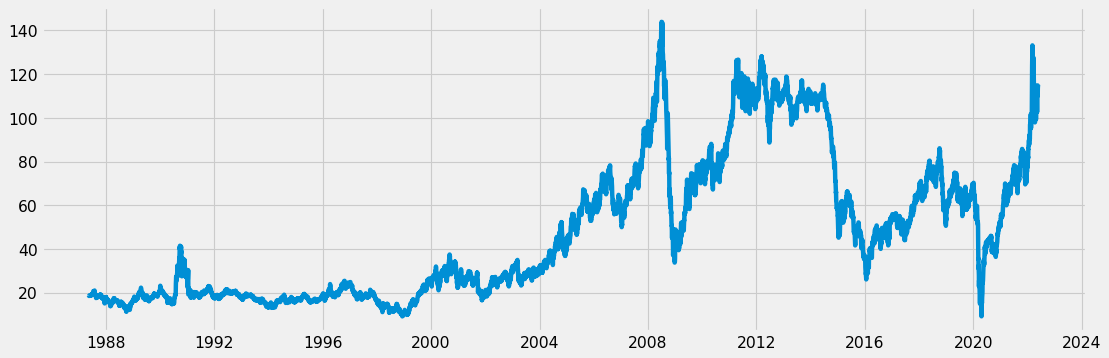

In [68]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=80) 
plt.plot(data)

#### THE Plot shows the frequency and fluctuation of the Oil price. We can see a huge drop down in Year 2008 after the World Crisis. The interesting fact: The Price after the Year 2008 become more unstable. The price of oil changes greatly in the remaining period.
#### It looks like cycles here. We see the up-and-down tendencies, and a relatively stable Plateau (2010-2014) in Prices.

### 2. Subsetting, wrangling, and cleaning time-series data

In [60]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [72]:
data_2.head()

,Date,Value
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [77]:
data_sub = data_2.loc[(data_2['Date'] >= '2008-01-01') & (data_2['Date'] < '2024-06-01')]

#### I choose the span from 2008-2024 to analyse. Time before was more stable and predictive.
#### The period starting from 2008 is significant due to the onset of the global financial crisis. This event led to drastic changes in economic conditions, market behaviors, and policy responses, making it a pivotal point for time series analysis.
#### The rise of shale oil production, particularly in the U.S., has influenced global oil supply and prices. Technological advancements in extraction have altered market dynamics.
#### Let's see what data after 2008 shows us in analysis 

In [79]:
data_sub.shape

(3641, 2)

In [84]:
data_sub.head()

,Date,Value
5246,2008-01-02,97.01
5247,2008-01-03,98.45
5248,2008-01-04,96.87
5249,2008-01-07,94.19
5250,2008-01-08,96.37


In [100]:
# The datetime module is essential for handling date and time data in Python, 
#providing a robust set of tools for manipulation and calculation.
# Let's import datetime module.

from datetime import datetime

In [92]:
# Set the "Date" column as the index

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date."

In [94]:
# Set the datetime as the index of the dataframe.

data_sub = data_sub.set_index('datetime')

In [96]:
# Drop the "Date" column.

data_sub.drop(['Date'], axis=1, inplace=True)

In [98]:
data_sub.head()

,Value
datetime,
2008-01-02,97.01
2008-01-03,98.45
2008-01-04,96.87
2008-01-07,94.19
2008-01-08,96.37


#### Let's see our data subset in Graph

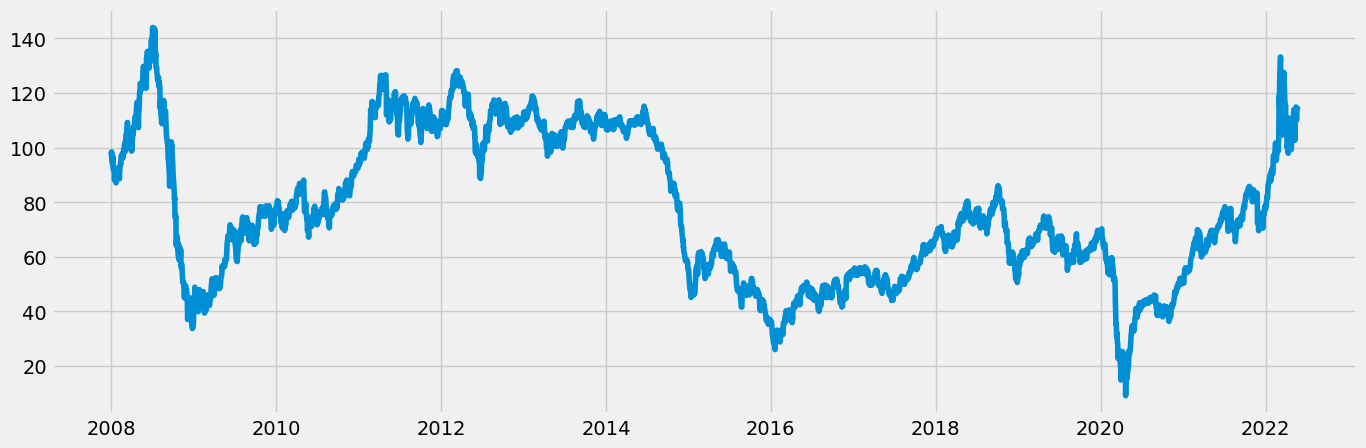

In [109]:
# Plot the new data subset from Year 2008-2024

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [203]:
# Check for missing values

data_sub.isnull().sum() 

Value    2374
dtype: int64

In [115]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# 759 dups!

759

In [121]:
# Removing duplicates
data_sub.drop_duplicates(inplace=True)

In [123]:
data_sub.shape

(2882, 1)

#### Let's see if dropping duplicates affects our Graph.
#### Looks the same

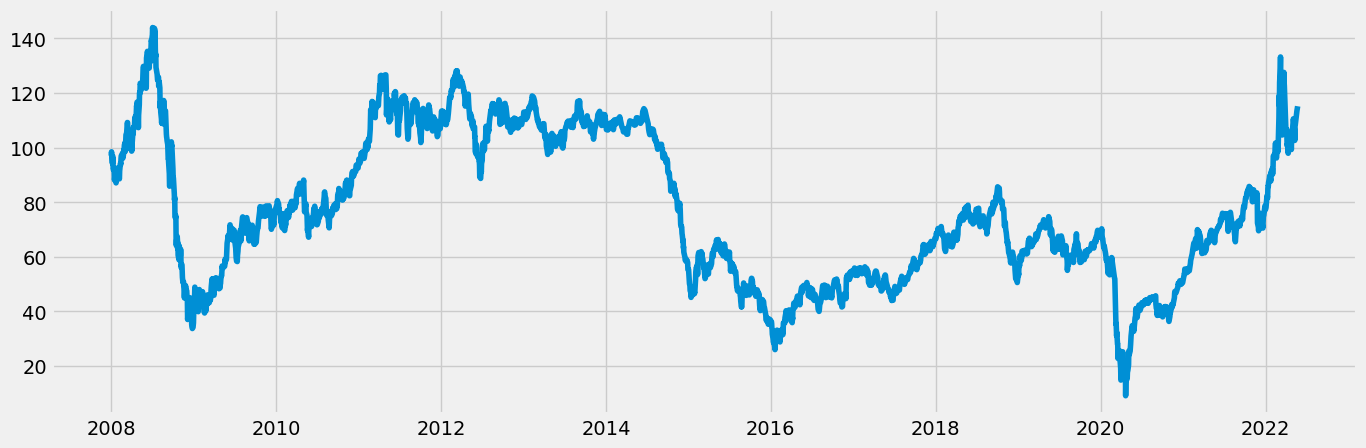

In [125]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### 3. Time-series analysis: decomposition

##### Preapring Data set for DECOMPOSITION

In [138]:
data_sub.head()

,Value
datetime,
2008-01-02,97.01
2008-01-03,98.45
2008-01-04,96.87
2008-01-07,94.19
2008-01-08,96.37


In [140]:
# Ensure the DatetimeIndex has a frequency set
data_sub = data_sub.asfreq('D')

In [146]:
# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(data_sub['Value'], model='multiplicative', period=365)

ValueError: This function does not handle missing values

In [161]:
# Let's avoid missing data
df_cleaned = data_sub.dropna()

In [152]:
df_cleaned.shape

(2882, 1)

In [154]:
# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df_cleaned['Value'], model='multiplicative', period=365)

#### I chose MULTIPLICATIVE model, because Oil Prices are change fast, unpredictevely and drastically. From cents to couple dollars(euros). 
#### In my opinion the changes in data behave in a non-linear fashion means that they’re more exponential or quadratic.

In [156]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

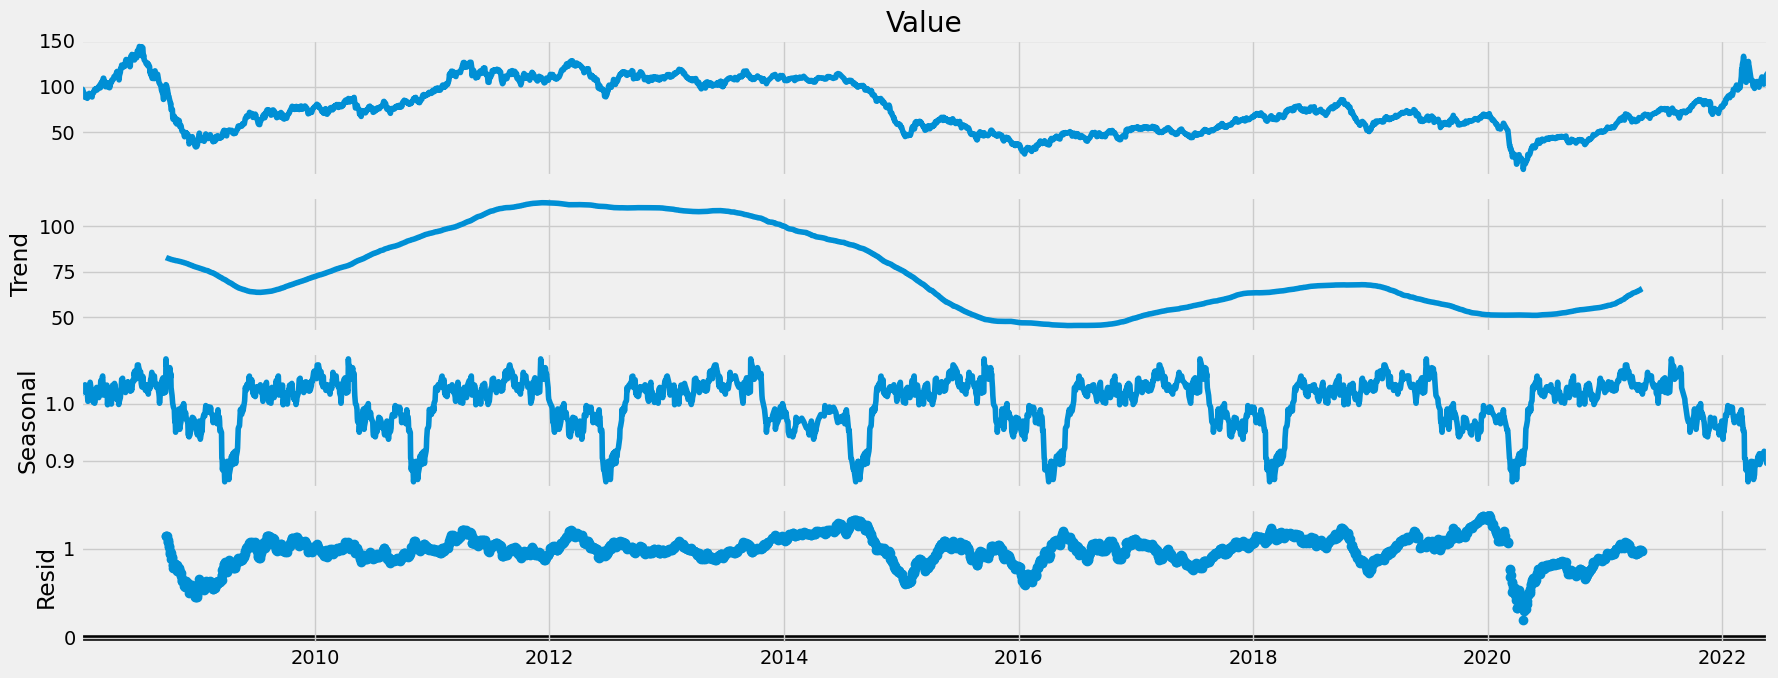

In [158]:
# Plot the separate components

decomposition.plot()
plt.show()

#### As we see we have the Trend goes up and down. Let's check the data for autocorrelation and non-stationarity. 

### 4. Testing for stationarity

In [169]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_cleaned['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   -2.374119
p-value                           0.149175
Number of Lags Used              28.000000
Number of Observations Used    2853.000000
Critical Value (1%)              -3.432644
Critical Value (5%)              -2.862554
Critical Value (10%)             -2.567310
dtype: float64


#### “Critical Value (5%)” in the results has a value of -2.862554. This is smaller than the test statistic, which is -2.374119, which means that we can’t reject the null hypothesis. This means that the data set is non-stationary

#### Checking for autocorrelation.

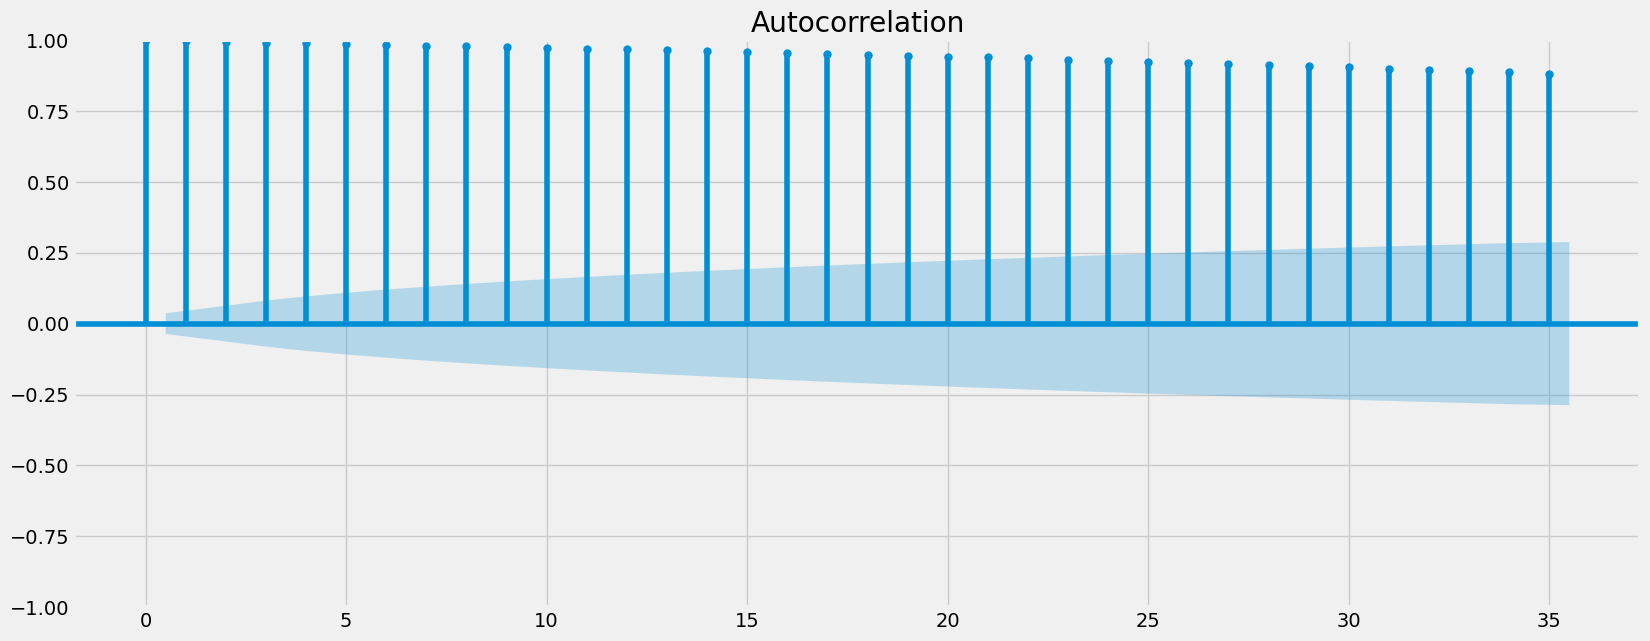

In [173]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(df_cleaned)
plt.show()

#### The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means we have lags that are significantly correlated with each other. And when we have many lags beyond this interval, we can deduce that our data is non-stationary

#### The Dickey-Fuller Stationary Test and Autocorrelation Test prove that we have a non-stationary data set.

### 5. Stationarizing the Crude Oil Prices: Brent - Europe [DCOILBRENTEU] data set.

#### Let's try Differencing method

In [180]:
data_diff = df_cleaned - df_cleaned.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [184]:
data_diff.dropna(inplace = True) # Remove the missing values that came about as a result of the differencing. 
# We need to remove these or you won't be able to run the Dickey-Fuller test.

In [186]:
data_diff.head()

,Value
datetime,
2008-01-03,1.44
2008-01-04,-1.58
2008-01-07,-2.68
2008-01-08,2.18
2008-01-09,0.39


In [188]:
data_diff.columns

Index(['Value'], dtype='object')

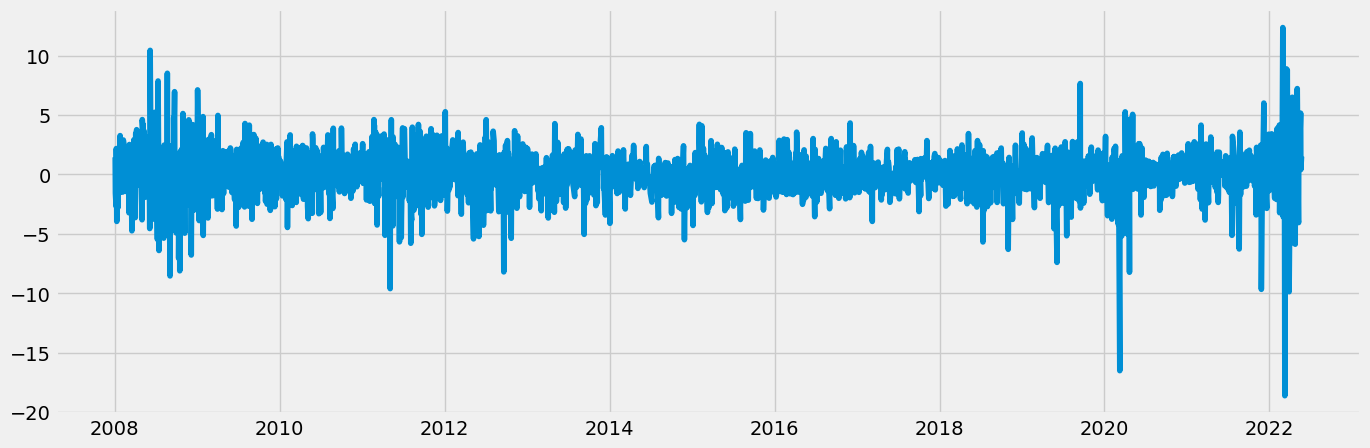

In [190]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

#### As we see, the line is more horizontal. We get rid of the Trend.

#### Now let's check Dickey-Fuller Test

In [194]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.228905e+00
p-value                        6.138548e-13
Number of Lags Used            2.800000e+01
Number of Observations Used    2.852000e+03
Critical Value (1%)           -3.432645e+00
Critical Value (5%)           -2.862554e+00
Critical Value (10%)          -2.567310e+00
dtype: float64


####  Test statistic is now smaller than the critical value at both the five and ten percent significance levels. This means we can consider our series stationary.

#### Let's check Autocorrelation

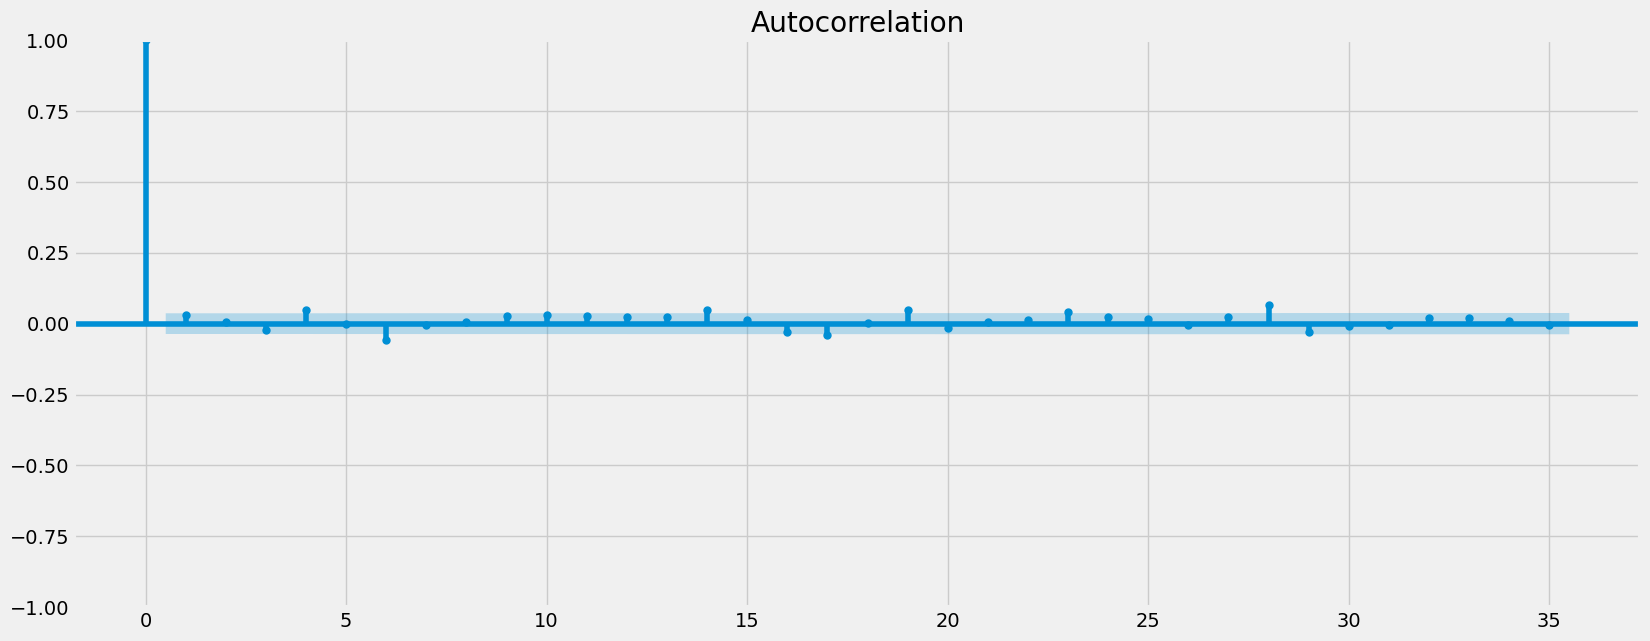

In [198]:
plot_acf(data_diff)
plt.show()

#### As we can clearly see we have several lags above the confidential level, which is ok. Now we can consider our data set as STATIONARY and provide further analysis -  FORECASTING